# Part 2: Analyze Neighborhoods in Toronto

## 1. Setup environment

In [5]:
# Install missing libraries
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install requests
!pip install geocoder
!pip install folium
!pip install geopandas

In [2]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import geocoder
from geopy.geocoders import Nominatim
import folium # map rendering library
from folium import plugins #Marker cluster object instiantiate
from IPython.core.display import HTML # render of html output
import json # library to handle JSON files
from sklearn.cluster import KMeans # import k-means from clustering stage
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from project_lib import Project # save data to cloud storage
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import re

print('Libraries imported.')

Libraries imported.


In [3]:
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='', project_access_token='')
pc = project.project_context

In [4]:
print('Project name: {}'.format(project.get_name()))
print('Project description: {}'.format(project.get_description()))

Project name: Peer_Project
Project description: Create a Jupyter Notebook using IBM Watson Studio. You can choose any language you want (Python, R, or Scala). You will need to include a combination of markdown and code cells. You will likely need to use the Markdown cheatsheet to help you determine the appropriate syntax to style your markdown.


## 2. Read source files

In [4]:
# source: open data portal of Toronto neighbourhoods
toronto_neighbourhoods = pd.read_csv(project.get_file('toronto_neighbourhoods.csv'))
toronto_neighbourhoods = toronto_neighbourhoods.drop(['_id','AREA_ID','AREA_ATTR_ID','AREA_DESC','PARENT_AREA_ID','AREA_LONG_CODE','X','Y','OBJECTID','geometry'],axis=1)
toronto_neighbourhoods.columns = ['Area Code','Area Name','Borough Name','Longitude','Latitude','Shape Area','Shape Length']
toronto_neighbourhoods.dtypes

Area Code         int64
Area Name        object
Borough Name     object
Longitude       float64
Latitude        float64
Shape Area      float64
Shape Length    float64
dtype: object

In [5]:
# source: open data portal of Toronto population
toronto_population = pd.read_csv(project.get_file('toronto_population.csv'))
toronto_population = toronto_population.drop(['Neighbourhood'], axis=1)
toronto_population.columns = ['Area Code','Total Population']
toronto_population['Area Code']=toronto_population['Area Code'].astype('int64')
toronto_population.dtypes

Area Code             int64
Total Population    float64
dtype: object

In [6]:
# @hidden_cell
toronto_area_venues = pd.read_csv(project.get_file('toronto_area_venues.csv'))
toronto_area_venues.dtypes

Area Code          int64
Distance           int64
Category name     object
Category short    object
Category long     object
dtype: object

In [8]:
# source: open data portal GIS information of Toronto borough
toronto_boroughs_edge = gpd.read_file("boroughs.shp")
toronto_boroughs_edge.dtypes

geometry    geometry
dtype: object

## 3. Generate Dataframe

In [9]:
# merge data with population based on area_code
toronto_data = toronto_neighbourhoods.merge(toronto_population, how='inner', left_on='Area Code', right_on='Area Code')
#toronto_data.head()

In [71]:
# calculate population denisty /km^2
toronto_data['Population Density'] = toronto_data['Total Population']/(toronto_data['Shape Area']/1e6)
toronto_data.head()

,Area Code,Area Name,Borough Name,Longitude,Latitude,Shape Area,Shape Length,Total Population,Population Density,Population Decile
0,1,West Humber-Clairville (1),Etobicoke,-79.596356,43.716180,5.775131e+07,38675.347816,33312.0,576.818110,1st
1,2,Mount Olive-Silverstone-Jamestown (2),Etobicoke,-79.587259,43.746868,8.893568e+06,17941.019557,32954.0,3705.374286,2nd
2,3,Thistletown-Beaumond Heights (3),Etobicoke,-79.563491,43.737988,6.402351e+06,14990.737781,10360.0,1618.155706,1st
3,4,Rexdale-Kipling (4),Etobicoke,-79.566228,43.723725,4.801397e+06,9788.586534,10529.0,2192.903219,1st
4,5,Elms-Old Rexdale (5),Etobicoke,-79.548983,43.721519,5.616463e+06,12955.634989,9456.0,1683.622000,1st


In [11]:
# Add decile's of population, muche easier to compare
toronto_data['Population Decile']=pd.cut(toronto_data['Population Density'],10,labels=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'])
toronto_data.head()

,Area Code,Area Name,Borough Name,Longitude,Latitude,Shape Area,Shape Length,Total Population,Population Density,Population Decile
0,1,West Humber-Clairville (1),Etobicoke,-79.596356,43.716180,5.775131e+07,38675.347816,33312.0,576.818110,1st
1,2,Mount Olive-Silverstone-Jamestown (2),Etobicoke,-79.587259,43.746868,8.893568e+06,17941.019557,32954.0,3705.374286,2nd
2,3,Thistletown-Beaumond Heights (3),Etobicoke,-79.563491,43.737988,6.402351e+06,14990.737781,10360.0,1618.155706,1st
3,4,Rexdale-Kipling (4),Etobicoke,-79.566228,43.723725,4.801397e+06,9788.586534,10529.0,2192.903219,1st
4,5,Elms-Old Rexdale (5),Etobicoke,-79.548983,43.721519,5.616463e+06,12955.634989,9456.0,1683.622000,1st


## 4. Exploring Boroughs in Toronto

### 1. Foursquare service credentials

In [1]:
# Claim access service credentials as per user/pwd
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

### 2. Explore nearby venues 
Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

In [72]:
# Use prevoius function to get venue data from Foursquare
def getNearbyVenues(area_codes, latitudes, longitudes, area_shapes, limit=200):
    
    venues_list=[]
    for area_code, lat, lng , area_shape in zip(area_codes, latitudes, longitudes, area_shapes):
        
        radius=np.sqrt((area_shape) / np.pi)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            area_code,
            #v['venue']['name'], 
            v['venue']['location']['distance'], 
            #v['venue']['location']['neighborhood'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['shortName'],
            v['venue']['categories'][0]['pluralName']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area Code', 
                  'Distance', 
                  #'Neighborhood', 
                  'Category name', 
                  'Category short',  
                  'Category long']
    
    return(nearby_venues)

In [73]:
# call function to retrieve desired data about venues in Toronto
toronto_area_venues = getNearbyVenues(
    area_codes=toronto_data['Area Code'],
    latitudes=toronto_data['Latitude'],
    longitudes=toronto_data['Longitude'],
    area_shapes=toronto_data['Shape Area'])

In [12]:
# Retrieved venues data
print('Number of venues in Toronto {}'.format(toronto_area_venues.shape))
toronto_area_venues.head()

Number of venues in Toronto (8930, 5)


,Area Code,Distance,Category name,Category short,Category long
0,94,372,Event Space,Event Space,Event Spaces
1,94,369,Farmers Market,Farmer's Market,Farmers Markets
2,94,547,Indian Restaurant,Indian,Indian Restaurants
3,94,520,BBQ Joint,BBQ,BBQ Joints
4,94,540,Café,Café,Cafés


In [13]:
# merge all restaurants in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('restaurants|steak|diners',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Restaurants'

In [14]:
# merge all shops in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('shops|butcher|boutique',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Shops'

In [15]:
# merge all stores in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('stores|markets|malls|supermarkets',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Stores'

In [16]:
# merge all pubs in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('pub|club|bars|breweries',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Bars'

In [17]:
# merge all fast-food places in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('joints|places|delis|noodle|chips',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Fast Food'

In [18]:
# merge all coffee places in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('coffee|caf.s|baker|breakfast|tea',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Coffee Shops'

In [19]:
# merge all transport facilities in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('station|bus',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Transport'

In [20]:
# merge all museums in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('theater|concert|museums|music|galleries|dance',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Art & Museums'

In [21]:
# merge all hotels/hostels in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('hotel|hostel',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Tourism'

In [22]:
# merge all sport places in a single category
toronto_filter = toronto_area_venues['Category long'].str.contains('golf|spas|gyms|skating|sports|pool|ball|yoga|soccer|hockey|tennis',flags=re.IGNORECASE,regex=True)
toronto_area_venues.loc[toronto_filter,'Category long'] = 'Sport & Leisure'

In [23]:
# keep mean and sum values per neighborhood
venues_density = toronto_area_venues.groupby(['Area Code']).agg(['mean','count']).reset_index()
# add deciles for mean distance among venues in a neighborhood
venues_density['Venue Distance Decile']=pd.cut(venues_density['Distance']['mean'],10,labels=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'])
# add deciles for number of venues in a neighborhood
venues_density['Venue Amount Decile']=pd.cut(venues_density['Distance']['count'],10,labels=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'])
#
venues_density.head()

Area Code     Distance       Venue Distance Decile Venue Amount Decile
                    mean count                                          
0         1  2704.760000   100                  10th                10th
1         2  1084.500000    30                   4th                 3rd
2         3   561.428571    21                   2nd                 2nd
3         4   780.866667    15                   2nd                 1st
4         5   932.250000    16                   3rd                 1st

In [24]:
print('There are {} uniques categories.'.format(len(toronto_area_venues['Category long'].unique())))

There are 115 uniques categories.


### 3. Analyze each Area Code
Calculate which venues are mos common as per PO, later on will be necessary for clustering

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_area_venues[['Category long']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Area Code'] = toronto_area_venues['Area Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Area Code,Airport Lounges,Airports,Animal Shelters,Aquariums,Arcades,Art & Museums,Auto Dealerships,Auto Garages,Badminton Courts,...,Tech Startups,Theme Parks,Tourism,Tracks,Trails,Transport,Transportation Services,Universities,Zoo Exhibits,Zoos
0,94,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,94,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,94,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,94,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Evaluate weighs of very feature by grouping and calculating mean values
toronto_grouped = toronto_onehot.groupby('Area Code').agg(['mean','sum']).reset_index()
toronto_grouped.head()

Area Code Airport Lounges     Airports     Animal Shelters     Aquariums  \
                       mean sum     mean sum            mean sum      mean   
0         1            0.01   1     0.01   1             0.0   0       0.0   
1         2            0.00   0     0.00   0             0.0   0       0.0   
2         3            0.00   0     0.00   0             0.0   0       0.0   
3         4            0.00   0     0.00   0             0.0   0       0.0   
4         5            0.00   0     0.00   0             0.0   0       0.0   

      Arcades  ... Transport     Transportation Services     Universities      \
  sum    mean  ...      mean sum                    mean sum         mean sum   
0   0     0.0  ...    0.0400   4                     0.0   0          0.0   0   
1   0     0.0  ...    0.1000   3                     0.0   0          0.0   0   
2   0     0.0  ...    0.0000   0                     0.0   0          0.0   0   
3   0     0.0  ...    0.0000   0                     0.0   0          0.0   0   
4   0     0.0  ...    0.0625   1                     0.0   0          0.0   0   

  Zoo Exhibits     Zoos      
          mean sum mean sum  
0          0.0   0  0.0   0  
1          0.0   0  0.0   0  
2          0.0   0  0.0   0  
3          0.0   0  0.0   0  
4          0.0   0  0.0   0  

[5 rows x 231 columns]

In [60]:
# Function that returns sorted venues
def return_most_common_venues(row):
    row = row.unstack().sort_values('mean',ascending=False)
    return row.index[0:10],row['sum'].values[0:10],row['mean'].values[0:10]

In [61]:
# sort venues occurences plus their mean and total number of occurences
idx = pd.IndexSlice
# Generate dataframe with most common venues per Postal Code
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area Code','Venue Distance Decile','Venue Amount Decile']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areacode_venues_sorted = pd.DataFrame(columns=columns)
#
areacode_venues_sorted['Area Code'] = toronto_grouped['Area Code']
#
areacode_venues_sorted['Venue Distance Decile'] = venues_density['Venue Distance Decile']
areacode_venues_sorted['Venue Amount Decile'] = venues_density['Venue Amount Decile']

for ind in np.arange(toronto_grouped.shape[0]):
    areacode_venues_sorted.iloc[ind, 3:] = return_most_common_venues(toronto_grouped.loc[idx[ind],idx[:,('mean','sum')]])

areacode_venues_sorted.head()

,Area Code,Venue Distance Decile,Venue Amount Decile,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,10th,10th,"[Restaurants, 35.0, 0.35]","[Shops, 20.0, 0.2]","[Fast Food, 7.0, 0.07]","[Tourism, 7.0, 0.07]","[Stores, 5.0, 0.05]","[Rental Car Locations, 4.0, 0.04]","[Transport, 4.0, 0.04]","[Sport & Leisure, 2.0, 0.02]","[Coffee Shops, 2.0, 0.02]","[Pharmacies, 2.0, 0.02]"
1,2,4th,3rd,"[Stores, 6.0, 0.2]","[Fast Food, 5.0, 0.16666666666666666]","[Restaurants, 4.0, 0.13333333333333333]","[Parks, 3.0, 0.1]","[Shops, 3.0, 0.1]","[Transport, 3.0, 0.1]","[Sport & Leisure, 2.0, 0.06666666666666667]","[Coffee Shops, 1.0, 0.03333333333333333]","[Pharmacies, 1.0, 0.03333333333333333]","[Residential Buildings (Apartments / Condos), ..."
2,3,2nd,2nd,"[Restaurants, 8.0, 0.38095238095238093]","[Stores, 4.0, 0.19047619047619047]","[Shops, 3.0, 0.14285714285714285]","[Pharmacies, 2.0, 0.09523809523809523]","[Banks, 2.0, 0.09523809523809523]","[Sport & Leisure, 1.0, 0.047619047619047616]","[Fast Food, 1.0, 0.047619047619047616]","[Airport Lounges, 0.0, 0.0]","[Post Offices, 0.0, 0.0]","[Plazas, 0.0, 0.0]"
3,4,2nd,1st,"[Stores, 5.0, 0.3333333333333333]","[Shops, 3.0, 0.2]","[Restaurants, 2.0, 0.13333333333333333]","[Fast Food, 2.0, 0.13333333333333333]","[Sport & Leisure, 1.0, 0.06666666666666667]","[Coffee Shops, 1.0, 0.06666666666666667]","[Parks, 1.0, 0.06666666666666667]","[Airport Lounges, 0.0, 0.0]","[Post Offices, 0.0, 0.0]","[Plazas, 0.0, 0.0]"
4,5,3rd,1st,"[Stores, 6.0, 0.375]","[Restaurants, 3.0, 0.1875]","[Fast Food, 2.0, 0.125]","[Shops, 2.0, 0.125]","[Sport & Leisure, 1.0, 0.0625]","[Storage Facilities, 1.0, 0.0625]","[Transport, 1.0, 0.0625]","[Parks, 0.0, 0.0]","[Performing Arts Venues, 0.0, 0.0]","[Pharmacies, 0.0, 0.0]"


### 4.Cluster Area Code
Use of K-Means algorithm to clusterize data

In [75]:
# dataframe to apply k-means algorithm
toronto_grouped_clustering = toronto_grouped.drop('Area Code', level=0, axis=1)
#
kmax = 15

In [63]:
# calculate sse error and check elbow point
sse = []

for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(toronto_grouped_clustering)
    sse.append(kmeans.inertia_)

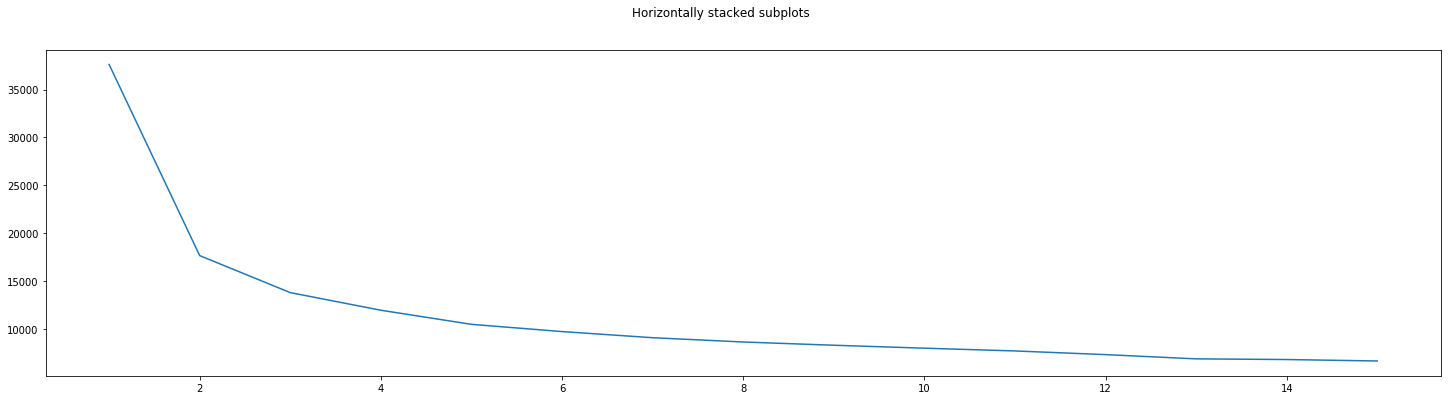

In [64]:
fig, ax1 = plt.subplots(1, 1, figsize=(25,6))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(range(1,kmax+1), sse)

In [65]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 2, 7, 2, 2, 1, 1, 4, 1, 1,
       3, 1, 3, 4, 4, 1, 1, 3, 4, 4, 7, 7, 3, 0, 0, 2, 6, 4, 6, 2, 4, 1,
       2, 4, 4, 2, 1, 7, 2, 7, 4, 3, 4, 4, 1, 3, 7, 3, 3, 4, 6, 7, 7, 7,
       6, 0, 7, 6, 1, 1, 6, 3, 6, 6, 6, 5, 5, 5, 5, 6, 7, 5, 7, 5, 6, 6,
       3, 4, 1, 7, 5, 0, 0, 6, 7, 6, 0, 0, 1, 3, 6, 0, 7, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 0, 1, 2, 2, 4, 3, 1, 3, 3, 3, 2, 2, 2, 7, 0, 7, 1,
       3, 3, 3, 3, 4, 3, 3, 3], dtype=int32)

In [67]:
# add clustering labels
areacode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# original data
toronto_merged = toronto_data
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(areacode_venues_sorted.set_index('Area Code'), on='Area Code')

### 5. Map Visualization
Plot the final clusterize dataframe

### 1. Gather data

In [73]:
# Proceed to fill nominatim inputs
address = 'Toronto, ON'
# user-agent: to_explorer
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, control_scale='True')

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#
toronto_boroughs_edge.crs = {'init':'epsg:4326'}
gjson = toronto_boroughs_edge.to_json()
points = folium.features.GeoJson(gjson)
map_clusters.add_child(points)


# add markers to the map
markers_colors = []
for lat, lon, area_name, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Area Name'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(area_name)+ ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

HTML(map_clusters._repr_html_())

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### 6. Examine clusters
Rational behind centroids clusterization
Note: On the first attempt to clusterize, the map showed all the nodes in just two clusters. Looks like all the points were isolated, so I increase the radius of the request to Foursquare from 500m to 1000m. Still is within a walking distance from {HOME}, and the results are quite different.


#### 1. Cluster = 0.

In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].head()

,Area Name,Borough Name,Population Decile,Venue Distance Decile,Venue Amount Decile,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Humber-Clairville (1),Etobicoke,1st,10th,10th,"[Restaurants, 35.0, 0.35]","[Shops, 20.0, 0.2]","[Fast Food, 7.0, 0.07]","[Tourism, 7.0, 0.07]","[Stores, 5.0, 0.05]","[Rental Car Locations, 4.0, 0.04]","[Transport, 4.0, 0.04]","[Sport & Leisure, 2.0, 0.02]","[Coffee Shops, 2.0, 0.02]","[Pharmacies, 2.0, 0.02]"
35,Newtonbrook West (36),North York,1st,5th,10th,"[Restaurants, 39.0, 0.39]","[Shops, 21.0, 0.21]","[Stores, 10.0, 0.1]","[Fast Food, 9.0, 0.09]","[Banks, 4.0, 0.04]","[Coffee Shops, 4.0, 0.04]","[Bars, 4.0, 0.04]","[Pharmacies, 4.0, 0.04]","[Playgrounds, 1.0, 0.01]","[Auto Dealerships, 1.0, 0.01]"
36,Willowdale West (37),North York,2nd,4th,10th,"[Restaurants, 38.0, 0.38]","[Shops, 21.0, 0.21]","[Fast Food, 14.0, 0.14]","[Stores, 11.0, 0.11]","[Bars, 3.0, 0.03]","[Parks, 2.0, 0.02]","[Art & Museums, 2.0, 0.02]","[Coffee Shops, 2.0, 0.02]","[Tourism, 1.0, 0.01]","[Sport & Leisure, 1.0, 0.01]"
67,North Riverdale (68),Old City of Toronto,2nd,2nd,10th,"[Restaurants, 37.0, 0.37]","[Shops, 14.0, 0.14]","[Coffee Shops, 10.0, 0.1]","[Bars, 9.0, 0.09]","[Stores, 9.0, 0.09]","[Sport & Leisure, 5.0, 0.05]","[Parks, 4.0, 0.04]","[Fast Food, 4.0, 0.04]","[Art & Museums, 2.0, 0.02]","[Bistros, 1.0, 0.01]"
93,Wychwood (94),Old City of Toronto,2nd,2nd,10th,"[Restaurants, 33.0, 0.3473684210526316]","[Shops, 13.0, 0.1368421052631579]","[Stores, 11.0, 0.11578947368421053]","[Fast Food, 8.0, 0.08421052631578947]","[Coffee Shops, 8.0, 0.08421052631578947]","[Bars, 5.0, 0.05263157894736842]","[Art & Museums, 3.0, 0.031578947368421054]","[Sport & Leisure, 2.0, 0.021052631578947368]","[Transport, 2.0, 0.021052631578947368]","[Intersections, 2.0, 0.021052631578947368]"


#### 2. Cluster = 1. 

In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].head()

,Area Name,Borough Name,Population Decile,Venue Distance Decile,Venue Amount Decile,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Thistletown-Beaumond Heights (3),Etobicoke,1st,2nd,2nd,"[Restaurants, 8.0, 0.38095238095238093]","[Stores, 4.0, 0.19047619047619047]","[Shops, 3.0, 0.14285714285714285]","[Pharmacies, 2.0, 0.09523809523809523]","[Banks, 2.0, 0.09523809523809523]","[Sport & Leisure, 1.0, 0.047619047619047616]","[Fast Food, 1.0, 0.047619047619047616]","[Airport Lounges, 0.0, 0.0]","[Post Offices, 0.0, 0.0]","[Plazas, 0.0, 0.0]"
17,New Toronto (18),Etobicoke,1st,2nd,3rd,"[Restaurants, 8.0, 0.2222222222222222]","[Shops, 6.0, 0.16666666666666666]","[Coffee Shops, 5.0, 0.1388888888888889]","[Fast Food, 4.0, 0.1111111111111111]","[Parks, 3.0, 0.08333333333333333]","[Stores, 3.0, 0.08333333333333333]","[Sport & Leisure, 2.0, 0.05555555555555555]","[Art & Museums, 1.0, 0.027777777777777776]","[Transport, 1.0, 0.027777777777777776]","[Bars, 1.0, 0.027777777777777776]"
18,Long Branch (19),Etobicoke,1st,2nd,3rd,"[Restaurants, 10.0, 0.29411764705882354]","[Fast Food, 5.0, 0.14705882352941177]","[Stores, 5.0, 0.14705882352941177]","[Shops, 3.0, 0.08823529411764706]","[Transport, 3.0, 0.08823529411764706]","[Coffee Shops, 2.0, 0.058823529411764705]","[Pharmacies, 2.0, 0.058823529411764705]","[Bars, 1.0, 0.029411764705882353]","[Beaches, 1.0, 0.029411764705882353]","[Sport & Leisure, 1.0, 0.029411764705882353]"
20,Humber Summit (21),North York,1st,5th,3rd,"[Restaurants, 9.0, 0.2571428571428571]","[Stores, 8.0, 0.22857142857142856]","[Fast Food, 4.0, 0.11428571428571428]","[Shops, 4.0, 0.11428571428571428]","[Banks, 2.0, 0.05714285714285714]","[Coffee Shops, 2.0, 0.05714285714285714]","[Transport, 1.0, 0.02857142857142857]","[Insurance Offices, 1.0, 0.02857142857142857]","[Tourism, 1.0, 0.02857142857142857]","[Pharmacies, 1.0, 0.02857142857142857]"
21,Humbermede (22),North York,1st,4th,2nd,"[Restaurants, 9.0, 0.375]","[Shops, 4.0, 0.16666666666666666]","[Stores, 3.0, 0.125]","[Coffee Shops, 2.0, 0.08333333333333333]","[Banks, 1.0, 0.041666666666666664]","[Bars, 1.0, 0.041666666666666664]","[Pharmacies, 1.0, 0.041666666666666664]","[Fast Food, 1.0, 0.041666666666666664]","[Parks, 1.0, 0.041666666666666664]","[Transport, 1.0, 0.041666666666666664]"


#### 3. Cluster = 2. Mainly represents North and East York Toronto area.

In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].head()

,Area Name,Borough Name,Population Decile,Venue Distance Decile,Venue Amount Decile,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Islington-City Centre West (14),Etobicoke,1st,8th,10th,"[Restaurants, 26.0, 0.26]","[Stores, 20.0, 0.2]","[Shops, 15.0, 0.15]","[Fast Food, 13.0, 0.13]","[Coffee Shops, 9.0, 0.09]","[Sport & Leisure, 8.0, 0.08]","[Bars, 4.0, 0.04]","[Art & Museums, 3.0, 0.03]","[Playgrounds, 1.0, 0.01]","[Food Courts, 1.0, 0.01]"
15,Stonegate-Queensway (16),Etobicoke,1st,6th,10th,"[Restaurants, 29.0, 0.29292929292929293]","[Shops, 16.0, 0.16161616161616163]","[Stores, 13.0, 0.13131313131313133]","[Fast Food, 13.0, 0.13131313131313133]","[Bars, 9.0, 0.09090909090909091]","[Coffee Shops, 6.0, 0.06060606060606061]","[Sport & Leisure, 5.0, 0.050505050505050504]","[Parks, 4.0, 0.04040404040404041]","[Art & Museums, 2.0, 0.020202020202020204]","[Food, 1.0, 0.010101010101010102]"
16,Mimico (includes Humber Bay Shores) (17),Etobicoke,1st,5th,10th,"[Restaurants, 34.0, 0.34]","[Fast Food, 13.0, 0.13]","[Stores, 12.0, 0.12]","[Shops, 11.0, 0.11]","[Coffee Shops, 9.0, 0.09]","[Bars, 5.0, 0.05]","[Parks, 4.0, 0.04]","[Sport & Leisure, 3.0, 0.03]","[Art & Museums, 3.0, 0.03]","[Banks, 2.0, 0.02]"
37,Lansing-Westgate (38),North York,1st,5th,10th,"[Restaurants, 27.0, 0.2903225806451613]","[Fast Food, 15.0, 0.16129032258064516]","[Shops, 14.0, 0.15053763440860216]","[Stores, 8.0, 0.08602150537634409]","[Bars, 4.0, 0.043010752688172046]","[Transport, 4.0, 0.043010752688172046]","[Coffee Shops, 4.0, 0.043010752688172046]","[Pharmacies, 3.0, 0.03225806451612903]","[Sport & Leisure, 3.0, 0.03225806451612903]","[Banks, 3.0, 0.03225806451612903]"
41,Banbury-Don Mills (42),North York,1st,5th,10th,"[Restaurants, 27.0, 0.27]","[Shops, 17.0, 0.17]","[Stores, 13.0, 0.13]","[Fast Food, 11.0, 0.11]","[Sport & Leisure, 6.0, 0.06]","[Bars, 4.0, 0.04]","[Coffee Shops, 4.0, 0.04]","[Parks, 3.0, 0.03]","[Art & Museums, 3.0, 0.03]","[Banks, 3.0, 0.03]"


#### 4. Cluster = 3. Altough belongs to North York, is represented as a single centroid, close to green park areas.

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]-3))]].shape

(39, 12)

#### 5. Cluster = 4. Mainly represents Etobicoke area, some outliers in Downtown Toronto and Scarborough.

In [80]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].shape

(16, 15)

#### 6. Cluster = 5.

In [81]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].shape

(7, 15)

#### 7. Cluster = 6.

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].shape

(15, 15)

#### 8. Cluster = 7.

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + [2] + [9] + list(range(11, toronto_merged.shape[1]))]].shape

(18, 15)

### 7. Analyze clusters

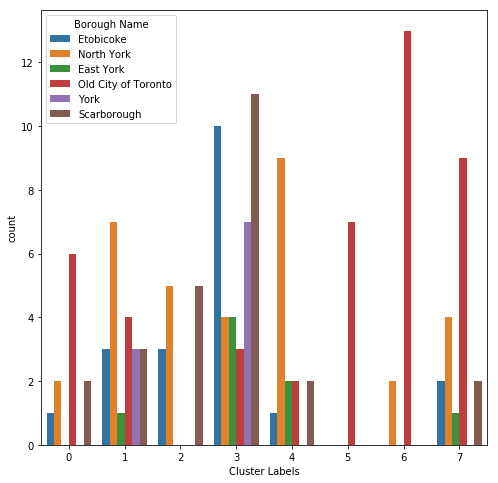

In [43]:
# Histogram to get a quick view of the results
plt.figure(figsize=(8,8))
splot = sns.countplot(x='Cluster Labels',hue='Borough Name',data=toronto_merged)

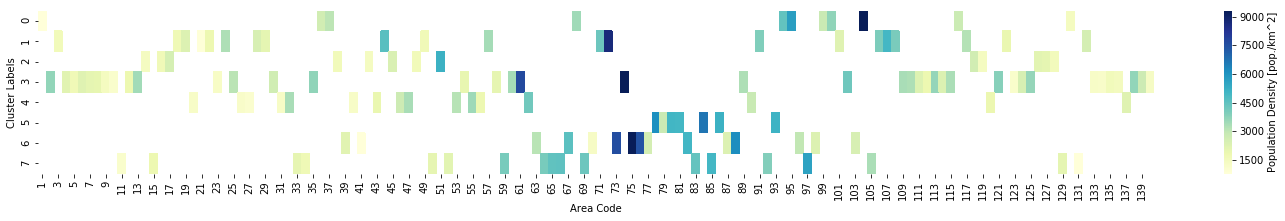

In [44]:
# heatplot aginst density
plt.figure(figsize=(25,3))
#

splot = sns.heatmap(toronto_merged.pivot(index='Cluster Labels',columns='Area Code',values='Population Density'),cmap="YlGnBu",robust=True,cbar_kws={'label': 'Population Density [pop./km^2]'})

Text(0, 0.5, 'Density')

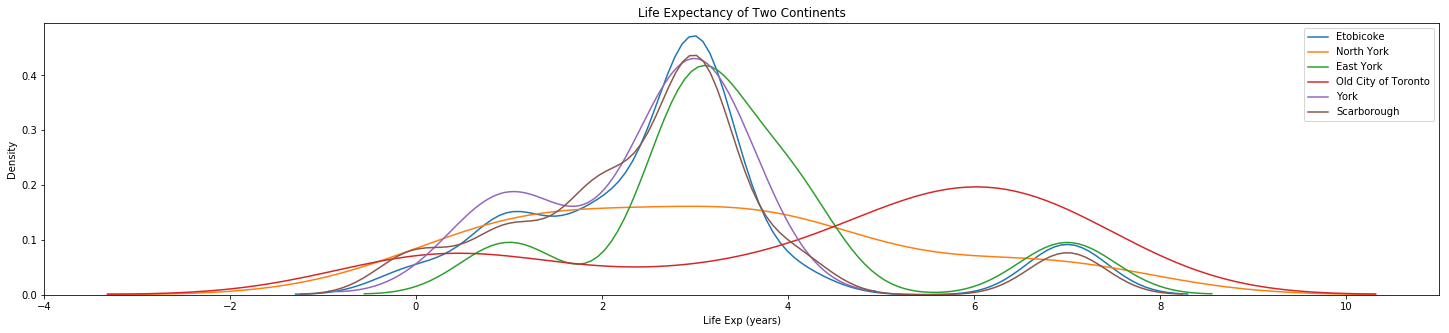

In [302]:
# Distribution plot using KDE estimator
plt.figure(figsize=(25,5))

splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='Etobicoke','Cluster Labels'],kde=True,hist=False, label='Etobicoke')
splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='North York','Cluster Labels'],kde=True,hist=False, label='North York')
splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='East York','Cluster Labels'],kde=True,hist=False, label='East York')
splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='Old City of Toronto','Cluster Labels'],kde=True,hist=False, label='Old City of Toronto')
splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='York','Cluster Labels'],kde=True,hist=False, label='York')
splot = sns.distplot(toronto_merged.loc[toronto_merged['Borough Name']=='Scarborough','Cluster Labels'],kde=True,hist=False, label='Scarborough')

plt.title('Life Expectancy of Two Continents')
plt.xlabel('Life Exp (years)')
plt.ylabel('Density')

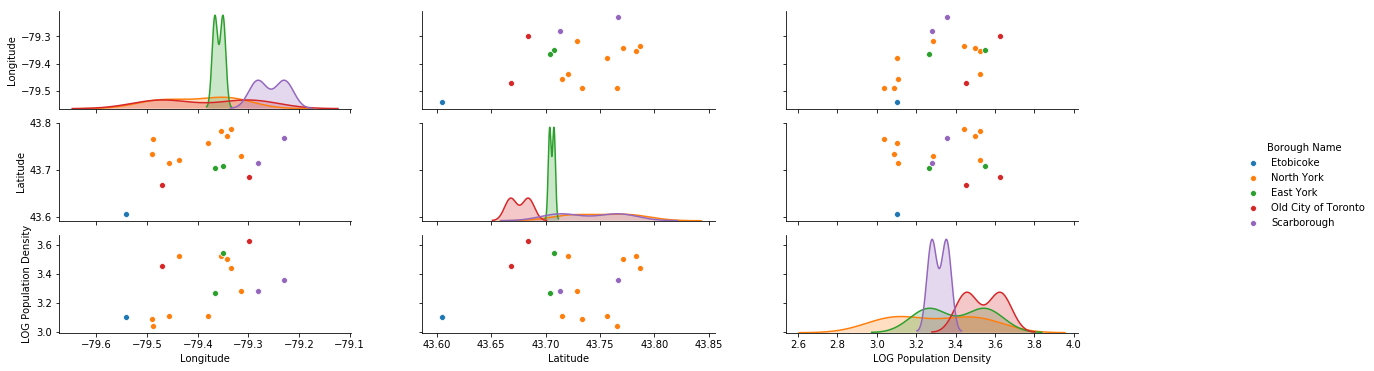

In [349]:
# More insights of the data for a prticular cluster
toronto_merged['LOG Population Density'] = np.log10(toronto_merged['Population Density'])

splot = sns.pairplot(toronto_merged.loc[toronto_merged['Cluster Labels'] == 4],vars=['Longitude','Latitude','LOG Population Density'],hue='Borough Name')

splot.fig.set_size_inches(20,5)

### End of Part 2